# Age at first marriage


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter

from utils import decorate
from utils import value_counts
from utils import resample_by_cycle
from utils import round_into_bins
from utils import remove_spines

from empiricaldist import Pmf, Cdf

random_seed = 1

<IPython.core.display.Javascript object>

In [4]:
# Make the figures smaller to save some screen real estate.
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [5, 3.7]

<IPython.core.display.Javascript object>

In [5]:
from utils import set_palette, resample_by_cycle

<IPython.core.display.Javascript object>

## Age at first marriage, female respondents

Load the data cleaned in `clean_nsfg.ipynb` and run the analysis with `lifelines`

In [6]:
%time resp = pd.read_hdf('FemMarriageData.hdf', 'FemMarriageData')
resp.shape

CPU times: user 57.1 ms, sys: 19 ms, total: 76.2 ms
Wall time: 80.9 ms


(75769, 46)

<IPython.core.display.Javascript object>

In [7]:
evrmarry = resp["evrmarry"]
value_counts(evrmarry)

evrmarry
False    36608
True     39161
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
for name, group in resp.groupby("birth_index"):
    missing = group["evrmarry"] & group["agemarry"].isna()
    print(name, missing.sum())

30 0
40 9
50 18
60 33
70 40
80 21
90 2
100 1


<IPython.core.display.Javascript object>

In [9]:
sample = resample_by_cycle(resp)

<IPython.core.display.Javascript object>

In [10]:
value_counts(sample["birth_index"])

birth_index
30       352
40      3866
50     10471
60     15382
70     18116
80     15471
90      9473
100     2638
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [11]:
def drop_missing(df):
    # find people who are married but have no agemarry
    missing = df["evrmarry"] & df["agemarry"].isna()
    return df[~missing]

<IPython.core.display.Javascript object>

In [12]:
def fill_missing(df):
    for cohort in range(30, 110, 10):
        # find people in this cohort who are married but have no agemarry
        missing = (df["birth_index"] == cohort) & df["evrmarry"] & df["agemarry"].isna()
        n = missing.sum()
        if n == 0:
            continue

        # find people in this cohort who have been married once
        donors = (df["birth_index"] == cohort) & df["evrmarry"] & df["agemarry"].notna()

        # select their ages when married
        agemarry = df.loc[donors, "agemarry"]
        low, high = np.percentile(agemarry, [1, 99])
        index = agemarry.between(low, high)

        # fill missing data with a random sample
        sample = np.random.choice(agemarry[index], size=n, replace=True)
        df.loc[missing, "agemarry"] = sample

<IPython.core.display.Javascript object>

In [13]:
# fill_missing(sample)
sample = drop_missing(sample)

missing = sample["evrmarry"] & sample["agemarry"].isna()
missing.sum()

0

<IPython.core.display.Javascript object>

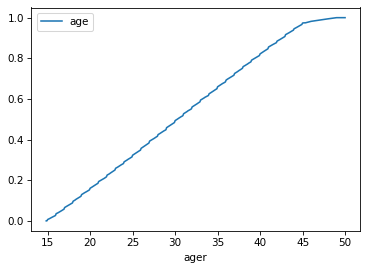

<IPython.core.display.Javascript object>

In [14]:
cdf = Cdf.from_seq(sample["ager"], name="age")
cdf.plot()
decorate()

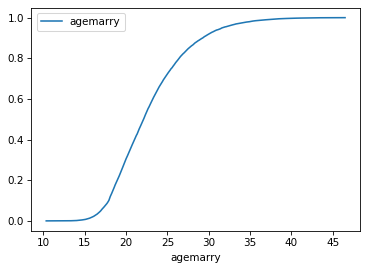

<IPython.core.display.Javascript object>

In [15]:
cdf = Cdf.from_seq(sample["agemarry"], name="agemarry")
cdf.plot()
decorate()

In [16]:
from utils import make_kmf_map

<IPython.core.display.Javascript object>

In [17]:
evrmarry = sample["evrmarry"]
sample["observed"] = evrmarry
sample.loc[evrmarry, "duration"] = sample["agemarry"]
sample.loc[~evrmarry, "duration"] = sample["ager"]

<IPython.core.display.Javascript object>

In [18]:
grouped = sample.groupby("birth_index")
nsfg_map = make_kmf_map(grouped)

<IPython.core.display.Javascript object>

In [19]:
from utils import add_text

<IPython.core.display.Javascript object>

In [20]:
def make_title(title, subtitle, pad=30):
    plt.title(title, loc="left", pad=pad)
    add_text(0, 1.085, subtitle)
    add_text(0, 1.015, "Analysis: allendowney.com/blog")

<IPython.core.display.Javascript object>

In [21]:
def decorate_plot(subtitle="", **options):
    decorate(
        xlabel="Age",
        ylabel="Percent",
        xlim=[13, 55],
        **options,
    )
    title = "Percent ever married"
    make_title(title, subtitle)

<IPython.core.display.Javascript object>

In [22]:
def plot_kmf_map(ax, kmf_map, cohorts, **options):
    """ """
    palette = set_palette("nipy_spectral", len(cohorts), reverse=True)
    for cohort in cohorts:
        series = kmf_map[cohort]
        label = f"{cohort+1900}s"
        series.plot(ax=ax, label=label, **options)
        label = ""

<IPython.core.display.Javascript object>

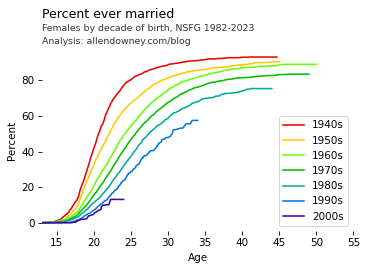

<IPython.core.display.Javascript object>

In [23]:
cohorts = range(40, 110, 10)

fig, ax = plt.subplots()
plot_kmf_map(ax, nsfg_map, cohorts)
decorate_plot(subtitle="Females by decade of birth, NSFG 1982-2023")
remove_spines()
plt.tight_layout()

In [24]:
def make_kmf_series(resp, iters=21):
    kmf_series = {}

    for i in range(iters):
        sample = resample_by_cycle(resp)
        sample = drop_missing(sample)
        evrmarry = sample["evrmarry"]
        sample["observed"] = evrmarry
        sample.loc[evrmarry, "duration"] = sample["agemarry"]
        sample.loc[~evrmarry, "duration"] = sample["ager"]
        grouped = sample.groupby("birth_index")
        kmf_map = make_kmf_map(grouped)
        for cohort in kmf_map:
            kmf_series.setdefault(cohort, []).append(kmf_map[cohort])

    return kmf_series

<IPython.core.display.Javascript object>

In [25]:
from utils import adjust_legend


def plot_kmf_series(kmf_series, cohorts, subtitle):
    # always make 7 colors, but only use the last n of them
    palette = sns.color_palette("nipy_spectral", 7)
    palette.reverse()
    n = len(cohorts)
    palette = palette[-n:]

    options = dict(alpha=0.1)

    for i, cohort in enumerate(cohorts):
        label = f"{cohort+1900}s"
        series_list = kmf_series[cohort]
        coords = []
        for series in series_list:
            coords.append((series.index[-1], series.iloc[-1]))
            series.plot(label=label, color=palette[i], **options)
            # only label the first line
            label = ""

    decorate_plot(subtitle, loc="lower right")
    adjust_legend(alpha=1, lw=2)
    remove_spines()
    plt.tight_layout()

<IPython.core.display.Javascript object>

In [26]:
kmf_series = make_kmf_series(resp)

<IPython.core.display.Javascript object>

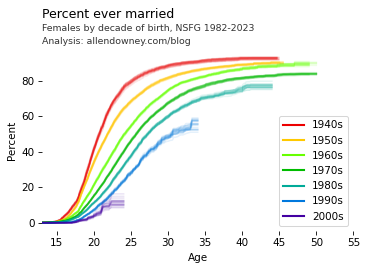

<IPython.core.display.Javascript object>

In [27]:
plot_kmf_series(
    kmf_series, cohorts, subtitle="Females by decade of birth, NSFG 1982-2023"
)
plt.savefig("marriage_female23.png", dpi=300)

## Percent married by education level

In [28]:
sample = resample_by_cycle(resp)

<IPython.core.display.Javascript object>

In [29]:
subset = sample.query("ager >=22 and ager < 25")

<IPython.core.display.Javascript object>

In [30]:
for name, group in subset.groupby("birth_index"):
    print(name, len(group))

50 663
60 1142
70 1508
80 1960
90 1815
100 341


<IPython.core.display.Javascript object>

In [31]:
subset.groupby("birth_index")["anycoll"].mean()

birth_index
50     0.422323
60     0.436077
70     0.561008
80     0.633673
90     0.665565
100    0.648094
Name: anycoll, dtype: float64

<IPython.core.display.Javascript object>

In [32]:
subset.groupby("birth_index")["evrmarry"].mean()

birth_index
50     0.601810
60     0.464098
70     0.442308
80     0.250510
90     0.170799
100    0.120235
Name: evrmarry, dtype: float64

<IPython.core.display.Javascript object>

In [33]:
def make_marriage_table(df, query):
    subset = df.query(query)
    table = subset.groupby(["birth_index", "anycoll"])["evrmarry"].mean().unstack()
    table.columns = ["No college", "Any college"]
    table.index = [f"{1900+cohort}s" for cohort in table.index]
    return table * 100

<IPython.core.display.Javascript object>

In [34]:
sample = resample_by_cycle(resp)
table = make_marriage_table(sample, "ager >=22 and ager < 25")

<IPython.core.display.Javascript object>

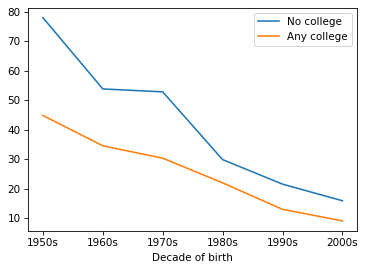

<IPython.core.display.Javascript object>

In [35]:
table.plot()
decorate(xlabel="Decade of birth")

In [36]:
sample = resample_by_cycle(resp)
table = make_marriage_table(sample, "ager >=32 and ager < 35")

<IPython.core.display.Javascript object>

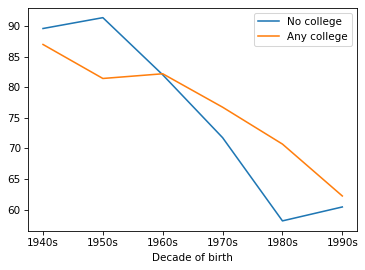

<IPython.core.display.Javascript object>

In [37]:
table.plot()
decorate(xlabel="Decade of birth")

In [38]:
from utils import percentile_rows


def plot_marriage_tables(tables):
    table = tables[0]
    categories = table.columns
    cohorts = table.index
    set_palette("Accent", len(categories), reverse=True)

    for col in table.columns:
        frame = pd.DataFrame(columns=cohorts)
        for i, table in enumerate(tables):
            frame.loc[i] = table[col]

        # using the 84% CI, so non-overlapping corresponds to
        # a difference that's significant at 5% level
        low, median, high = percentile_rows(frame, [8, 50, 92])
        plt.fill_between(cohorts, low, high, alpha=0.2)
        plt.plot(cohorts, median, label=col)

<IPython.core.display.Javascript object>

In [39]:
tables23 = [
    make_marriage_table(resample_by_cycle(resp), "ager >=22 and ager < 25")
    for i in range(101)
]

<IPython.core.display.Javascript object>

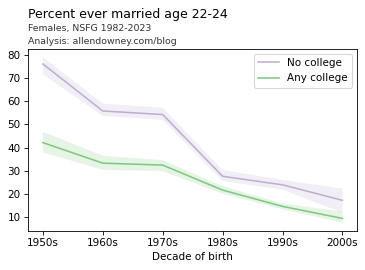

<IPython.core.display.Javascript object>

In [40]:
plot_marriage_tables(tables23)
make_title(title="Percent ever married age 22-24", subtitle="Females, NSFG 1982-2023 ")
decorate(xlabel="Decade of birth")

In [41]:
tables34 = [
    make_marriage_table(resample_by_cycle(resp), "ager >=32 and ager < 35")
    for i in range(101)
]

<IPython.core.display.Javascript object>

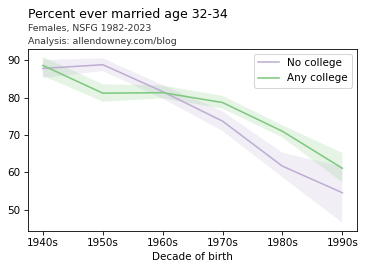

<IPython.core.display.Javascript object>

In [42]:
plot_marriage_tables(tables34)
make_title(title="Percent ever married age 32-34", subtitle="Females, NSFG 1982-2023 ")
decorate(xlabel="Decade of birth")

## Age at first marriage, male respondents

Load the data cleaned in `clean_nsfg.ipynb` and run the analysis with `lifelines`

In [43]:
%time resp2 = pd.read_hdf('MaleMarriageData.hdf', 'MaleMarriageData')
resp.shape

CPU times: user 15.7 ms, sys: 3.97 ms, total: 19.6 ms
Wall time: 19.2 ms


(75769, 46)

<IPython.core.display.Javascript object>

In [44]:
evrmarry = resp2["evrmarry"]
value_counts(evrmarry)

evrmarry
False    24634
True     14135
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [45]:
for name, group in resp2.groupby("birth_index"):
    missing = group["evrmarry"] & group["agemarry"].isna()
    print(name, missing.sum())

50 0
60 0
70 1
80 1
90 1
100 0


<IPython.core.display.Javascript object>

In [46]:
sample = resample_by_cycle(resp2)

<IPython.core.display.Javascript object>

In [47]:
value_counts(sample["birth_index"])

birth_index
50       373
60      4862
70     11219
80     12059
90      8268
100     1988
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [48]:
sample = drop_missing(sample)

missing = sample["evrmarry"] & sample["agemarry"].isna()
missing.sum()

0

<IPython.core.display.Javascript object>

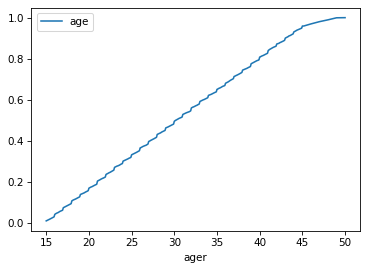

<IPython.core.display.Javascript object>

In [49]:
cdf = Cdf.from_seq(sample["ager"], name="age")
cdf.plot()
decorate()

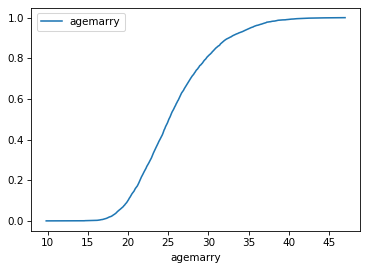

<IPython.core.display.Javascript object>

In [50]:
cdf = Cdf.from_seq(sample["agemarry"], name="agemarry")
cdf.plot()
decorate()

In [51]:
evrmarry = sample["evrmarry"]
sample["observed"] = evrmarry
sample.loc[evrmarry, "duration"] = sample["agemarry"]
sample.loc[~evrmarry, "duration"] = sample["ager"]

<IPython.core.display.Javascript object>

In [52]:
grouped = sample.groupby("birth_index")
nsfg_map = make_kmf_map(grouped)

<IPython.core.display.Javascript object>

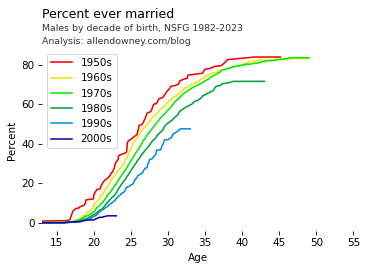

<IPython.core.display.Javascript object>

In [53]:
cohorts = range(50, 110, 10)

fig, ax = plt.subplots()
plot_kmf_map(ax, nsfg_map, cohorts)

decorate_plot(subtitle="Males by decade of birth, NSFG 1982-2023")
remove_spines()
plt.tight_layout()

In [54]:
kmf_series = make_kmf_series(resp2)

<IPython.core.display.Javascript object>

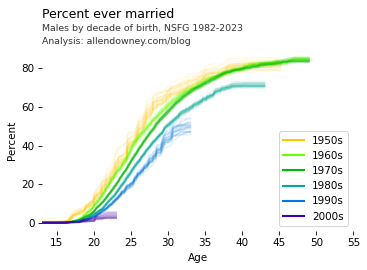

<IPython.core.display.Javascript object>

In [55]:
plot_kmf_series(
    kmf_series, cohorts, subtitle="Males by decade of birth, NSFG 1982-2023"
)
plt.savefig("marriage_male23.png", dpi=300)

## Percent married by education level, males

In [56]:
sample = resample_by_cycle(resp2)

<IPython.core.display.Javascript object>

In [57]:
subset = sample.query("ager >=22 and ager < 25")

<IPython.core.display.Javascript object>

In [58]:
for name, group in subset.groupby("birth_index"):
    print(name, len(group))

70 350
80 1599
90 1475
100 268


<IPython.core.display.Javascript object>

In [59]:
subset.groupby("birth_index")["anycoll"].mean()

birth_index
70     0.480000
80     0.577861
90     0.581695
100    0.529851
Name: anycoll, dtype: float64

<IPython.core.display.Javascript object>

In [60]:
subset.groupby("birth_index")["evrmarry"].mean()

birth_index
70     0.245714
80     0.168230
90     0.118644
100    0.041045
Name: evrmarry, dtype: float64

<IPython.core.display.Javascript object>

In [61]:
table = make_marriage_table(sample, "ager >=22 and ager < 25")

<IPython.core.display.Javascript object>

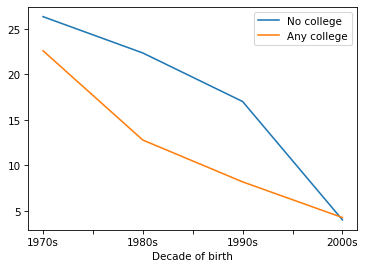

<IPython.core.display.Javascript object>

In [62]:
table.plot()
decorate(xlabel="Decade of birth")

In [63]:
table = make_marriage_table(sample, "ager >=32 and ager < 35")

<IPython.core.display.Javascript object>

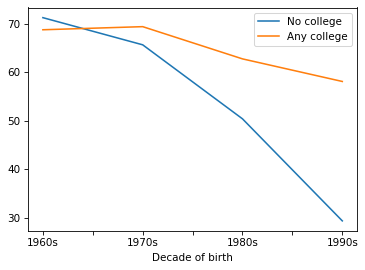

<IPython.core.display.Javascript object>

In [64]:
table.plot()
decorate(xlabel="Decade of birth")

In [65]:
tables23 = [
    make_marriage_table(resample_by_cycle(resp2), "ager >=22 and ager < 25")
    for i in range(101)
]

<IPython.core.display.Javascript object>

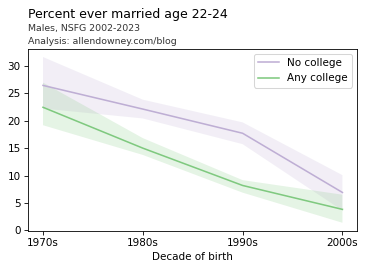

<IPython.core.display.Javascript object>

In [66]:
plot_marriage_tables(tables23)
make_title(title="Percent ever married age 22-24", subtitle="Males, NSFG 2002-2023 ")
decorate(xlabel="Decade of birth")

In [67]:
tables34 = [
    make_marriage_table(resample_by_cycle(resp2), "ager >=32 and ager < 35")
    for i in range(101)
]

<IPython.core.display.Javascript object>

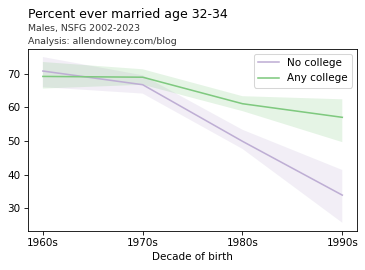

<IPython.core.display.Javascript object>

In [68]:
plot_marriage_tables(tables34)
make_title(title="Percent ever married age 32-34", subtitle="Males, NSFG 2002-2023 ")
decorate(xlabel="Decade of birth")